In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

%matplotlib inline

In [2]:
##data = pd.read_csv('C:/Users/lizil/Dropbox/Job/Data/Fraud-Detection-master/Fraud_Data/Fraud_Data.csv',parse_dates = ['signup_time','purchase_time'])
data = pd.read_csv('/Users/adamichael/Dropbox/Job/Data/Fraud-Detection-master/Fraud_Data/Fraud_Data.csv',parse_dates = ['signup_time','purchase_time'])
data.head(10)
## read_csv里加上parse_dates可以直接把想要把date格式的colunn parse成datetime

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,2.809315e+09,0
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,3.987484e+09,0
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,1.692459e+09,0
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,3.719094e+09,0
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,3.416747e+08,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: datetime64[ns](2), float64(1), int64(4), object(4)
memory usage: 12.7+ MB


In [4]:
##address_data = pd.read_csv('C:/Users/lizil/Dropbox/Job/Data/Fraud-Detection-master/Fraud_Data/IpAddress_to_Country.csv')
address_data = pd.read_csv('/Users/adamichael/Dropbox/Job/Data/Fraud-Detection-master/Fraud_Data/IpAddress_to_Country.csv')

In [5]:
address_data.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Merge country into main data for further analysis

In [6]:
countries = []
for i in range(len(data)):
    ip_address = data.loc[i,'ip_address']
    tmp = address_data[(address_data['lower_bound_ip_address']<=ip_address) & 
                      (address_data['upper_bound_ip_address']>=ip_address)]
    if len(tmp)==1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
data['countries'] = countries


In [7]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,countries
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
countries         151112 non-null object
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.8+ MB


In [9]:
data.shape

(151112, 12)

# Feature Engineering

## Time difference

In [10]:
time_diff = data['purchase_time']-data['signup_time']

In [11]:
time_diff = time_diff.apply(lambda x: x.seconds)

In [12]:
data['time_diff']=time_diff

## Check user number for unique device

In [13]:
## if multiple users share same device, it is more likely a fraud activity

In [14]:
device_num = data[['user_id', 'device_id']].groupby('device_id').count().reset_index()

In [15]:
device_num = device_num.rename(columns={'user_id': 'device_num'})

In [16]:
device_num.head()

,device_id,device_num
0,AAALBGNHHVMKG,1
1,AAAWIHVCQELTP,1
2,AAAXJHWCLISKY,1
3,AAAXXOZJRZRAO,11
4,AABFGRPBQHWFQ,1


In [17]:
data = data.merge(device_num, how='left', on='device_id')

## check user number for unique IP address

In [18]:
## if multiple users share same IP, it is more likely a fraud activity

In [19]:
ip_num = data[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()

In [20]:
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
data = data.merge(ip_num, how='left', on='ip_address')

## Sign up/Purchase Day of Week and Week

In [21]:
data['signup_day'] = data['signup_time'].apply(lambda x: x.dayofweek)
data['signup_week'] = data['signup_time'].apply(lambda x: x.week)
data['purchase_day'] = data['purchase_time'].apply(lambda x: x.dayofweek)
data['purchase_week'] = data['purchase_time'].apply(lambda x: x.week)

In [22]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,countries,time_diff,device_num,ip_num,signup_day,signup_week,purchase_day,purchase_week
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,1,1,9,5,16
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,1,1,6,23,0,24
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,12,12,3,1,3,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,1,1,18,0,19
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,1,1,30,2,37


# Fit Model

## select model features and targets

In [23]:
columns = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 'source', 
           'browser', 'sex', 'age', 'countries', 'time_diff', 'device_num', 'ip_num', 'class']
data = data[columns]
data.head()

,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,countries,time_diff,device_num,ip_num,class
0,1,9,5,16,34,SEO,Chrome,M,39,Japan,13882,1,1,0
1,6,23,0,24,16,Ads,Chrome,F,53,United States,17944,1,1,0
2,3,1,3,1,15,SEO,Opera,M,53,United States,1,12,12,1
3,1,18,0,19,44,SEO,Safari,M,41,NA,60085,1,1,0
4,1,30,2,37,39,Ads,Safari,M,45,United States,41461,1,1,0


## initiate the model

In [24]:
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_101"; Java(TM) SE Runtime Environment (build 1.8.0_101-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.101-b13, mixed mode)
  Starting server from /Users/adamichael/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/0k/yh14kvb53z332ckrh5l_n0wr0000gn/T/tmpb96s_1p0
  JVM stdout: /var/folders/0k/yh14kvb53z332ckrh5l_n0wr0000gn/T/tmpb96s_1p0/h2o_adamichael_started_from_python.out
  JVM stderr: /var/folders/0k/yh14kvb53z332ckrh5l_n0wr0000gn/T/tmpb96s_1p0/h2o_adamichael_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,4 months and 21 days !!!
H2O_cluster_name:,H2O_from_python_adamichael_hb4hi6
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


## categorize all factor columns

In [25]:
h2o_df = H2OFrame(data)

for name in ['signup_day', 'purchase_day', 'source', 'browser', 'sex', 'countries', 'class']:
    h2o_df[name] = h2o_df[name].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,signup_day,signup_week,purchase_day,purchase_week,purchase_value,source,browser,sex,age,countries,time_diff,device_num,ip_num,class
type,enum,int,enum,int,int,enum,enum,enum,int,enum,int,int,int,enum
mins,,1.0,,1.0,9.0,,,,18.0,,1.0,1.0,1.0,
mean,,16.501740430938508,,24.658571126052173,36.93537243898567,,,,33.14070358409671,,40942.584427444956,1.6843665625496433,1.6027185134205137,
maxs,,34.0,,51.0,154.0,,,,76.0,,86399.0,20.0,20.0,
sigma,,9.814287461798854,,11.651556782719474,18.32276214866212,,,,8.617733490961495,,26049.661902118358,2.6169536028041693,2.596239527375835,
zeros,,0,,0,0,,,,0,,0,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1,9.0,5,16.0,34.0,SEO,Chrome,M,39.0,Japan,13882.0,1.0,1.0,0
1,6,23.0,0,24.0,16.0,Ads,Chrome,F,53.0,United States,17944.0,1.0,1.0,0
2,3,1.0,3,1.0,15.0,SEO,Opera,M,53.0,United States,1.0,12.0,12.0,1


## split the train/test data

In [26]:
strat_split = h2o_df['class'].stratified_split(test_frac=0.3, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

## split the feature/target

In [29]:
feature = ['signup_day', 'signup_week', 'purchase_day', 'purchase_week', 'purchase_value', 
           'source', 'browser', 'sex', 'age', 'countries', 'time_diff', 'device_num', 'ip_num']
target = 'class'

## build model

In [30]:
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, mtries=-1, stopping_rounds=5, 
                                 stopping_metric='auc', score_each_iteration=True, seed=42)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [31]:
model.score_history()


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2021-02-19 11:16:26,0.111 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,,2021-02-19 11:16:27,1.181 sec,1.0,0.330323,0.761666,0.954907,0.943521,1.932086,0.106435,0.255427,1.633138,0.782921,0.492657,7.433134,0.063706
2,,2021-02-19 11:16:27,1.883 sec,2.0,0.333707,0.662977,0.959580,0.950770,1.945869,0.100341,0.212081,0.672350,0.804631,0.646843,10.168294,0.045684
3,,2021-02-19 11:16:28,2.450 sec,3.0,0.337360,0.577955,0.962921,0.957209,1.959744,0.096653,0.205984,0.441324,0.818400,0.676280,10.585434,0.044250
4,,2021-02-19 11:16:28,2.917 sec,4.0,0.338654,0.532992,0.965244,0.961374,1.967643,0.092693,0.204538,0.348968,0.824291,0.684465,10.646046,0.044184
5,,2021-02-19 11:16:29,3.329 sec,5.0,0.340130,0.490398,0.967536,0.965426,1.975654,0.091093,0.203784,0.302226,0.827033,0.688552,10.655368,0.044339
6,,2021-02-19 11:16:29,3.794 sec,6.0,0.336884,0.451830,0.972704,0.970854,1.980406,0.082898,0.203543,0.280094,0.830336,0.691512,10.679152,0.044118
7,,2021-02-19 11:16:30,4.237 sec,7.0,0.336006,0.420208,0.976209,0.975076,1.985450,0.080232,0.203377,0.259090,0.832615,0.692911,10.679152,0.044449
8,,2021-02-19 11:16:30,4.719 sec,8.0,0.334299,0.396043,0.979516,0.978680,1.988771,0.074378,0.203280,0.248835,0.833230,0.695027,10.679152,0.044405
9,,2021-02-19 11:16:31,5.251 sec,9.0,0.335495,0.381204,0.981866,0.981348,1.991627,0.069957,0.203173,0.232175,0.834438,0.696937,10.679152,0.044184


## show feature importance

In [32]:
importance = model.varimp(use_pandas=True)


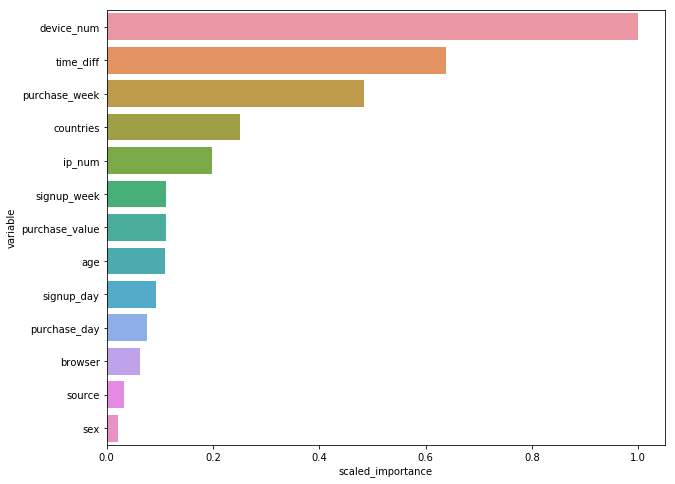

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

## make auc curve

In [40]:
## train/test are all H2O frame, to fetch specific columns values, need to covert back to data frame using as_data_frame()
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
## to predict the target on certain dataset in H2O, just use model.predict(dataset), 'p0' is the probability of class 0, and 
## "p1" is the probability of class 1
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [42]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

In [60]:
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))


              precision    recall  f1-score   support

           0       0.95      1.00      0.98     41088
           1       1.00      0.53      0.69      4245

   micro avg       0.96      0.96      0.96     45333
   macro avg       0.98      0.76      0.83     45333
weighted avg       0.96      0.96      0.95     45333



In [61]:
train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)


In [62]:
train_fpr

array([0.        , 0.        , 0.        , ..., 0.98413526, 0.98417698,
       1.        ])

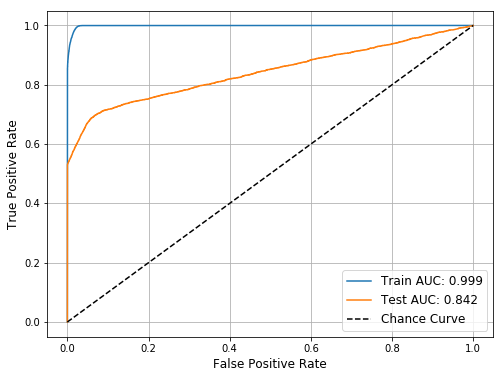

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


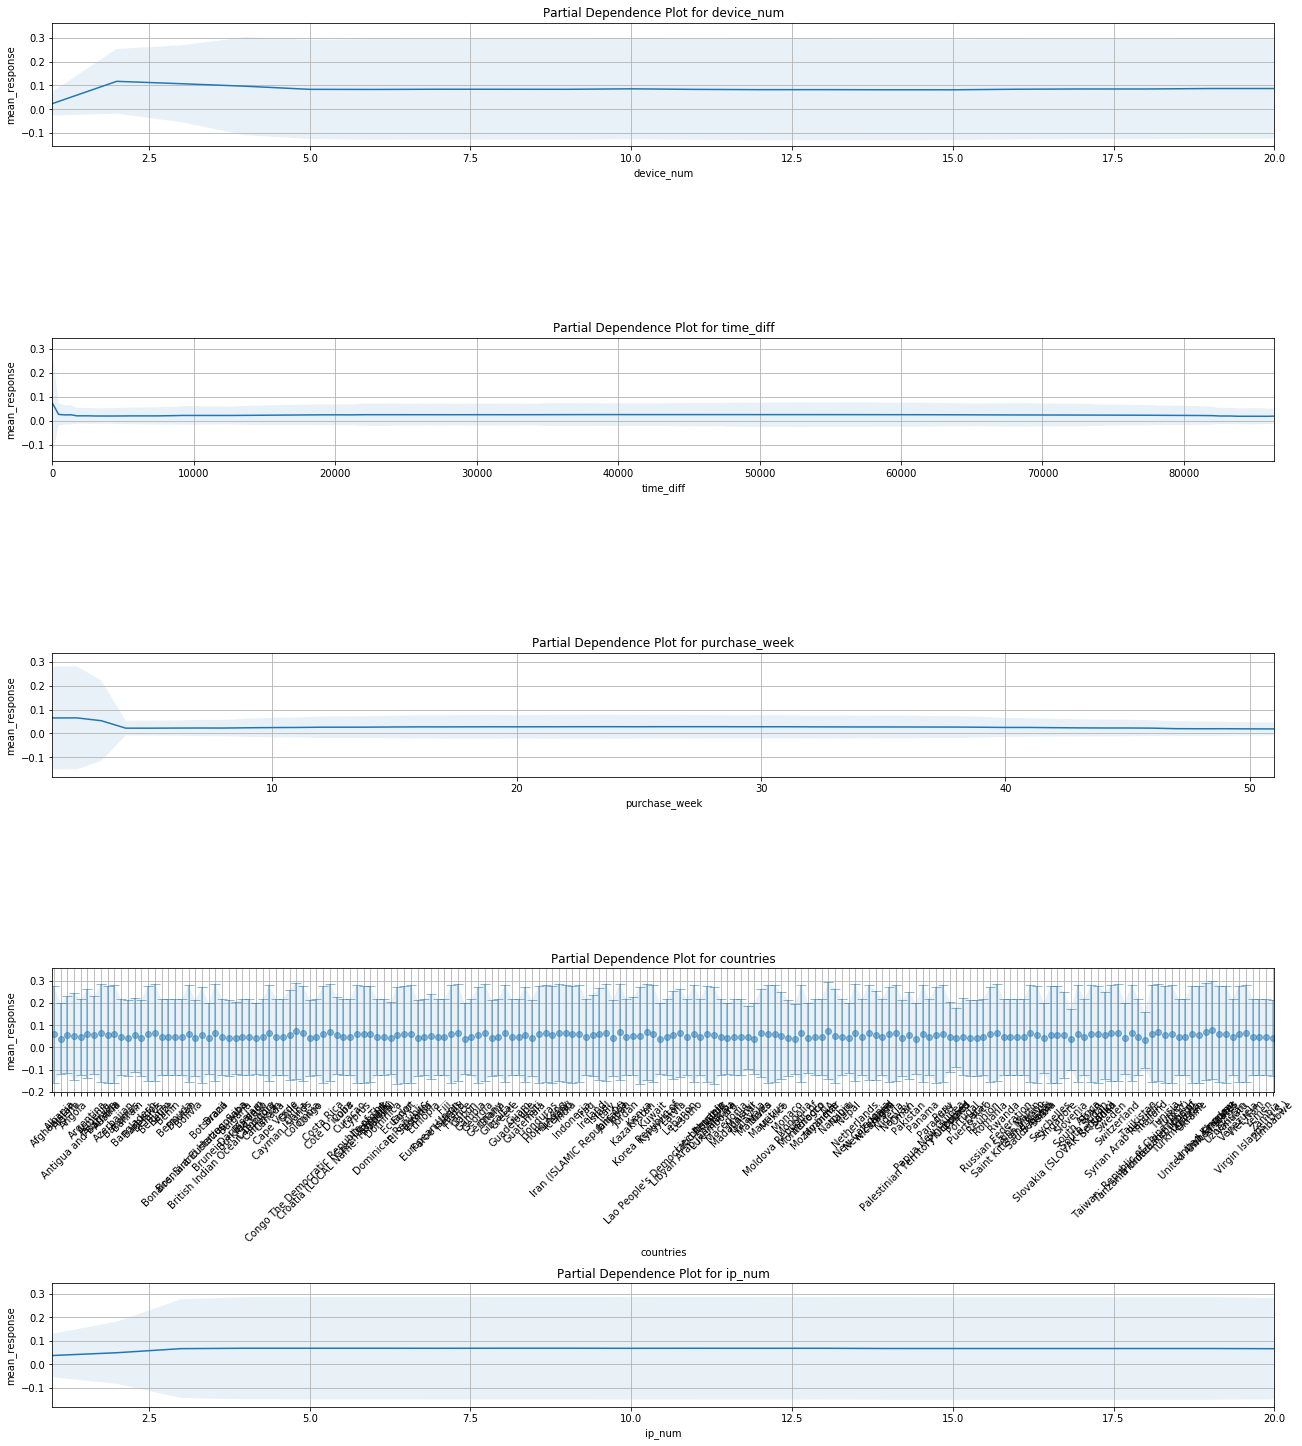

In [65]:
cols = ['device_num', 'time_diff', 'purchase_week', 'countries', 'ip_num']
_ = model.partial_plot(data=train, cols=cols, nbins=200, figsize=(18, 20))

In [ ]:
"""
Some further source:
1. to determine the degree of aggressive when predict fraud, we can simply adjust the threshold above. The higher the threshold, there will be less positive (TP + FP),
so less aggressive; if decreasing the threshold, there will be more TP + FP, therefore more aggressive
2. In practice, since each obs is associated with a probability of fraud, we can therefore drop several business/practical 
threshold to differenctial different degrees of fraud (no fraud/less likely/likely/definitely), etc, and prepare different actions
on different categories above

"""